# Importing dependencies

In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Using GPU:", tf.test.gpu_device_name())

Num GPUs Available: 1
Using GPU: /device:GPU:0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# EDA

In [3]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)

(568454, 10)


In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


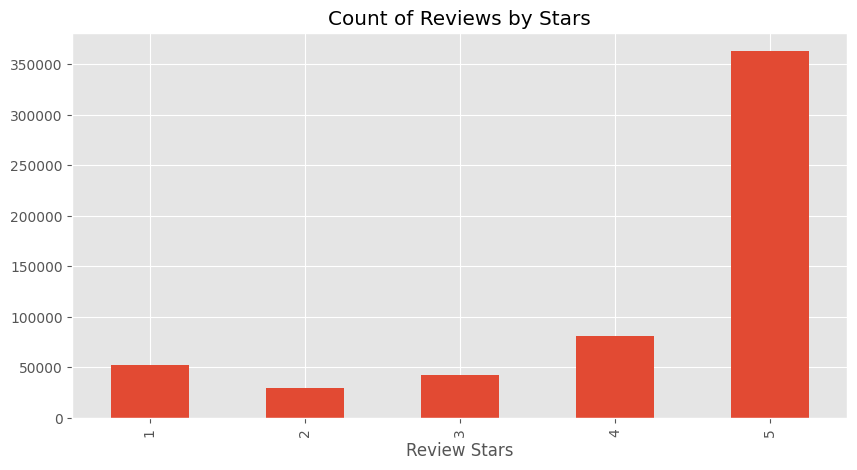

In [5]:
plt.style.use('ggplot')
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [6]:
ex = df['Text'][50]
print(ex)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [7]:
tokens = nltk.word_tokenize(ex)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [9]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Sentiment analysis using VADER

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

Senti = SentimentIntensityAnalyzer()

/usr/local/lib/python3.10/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [11]:
Senti.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [12]:
Senti.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [13]:
Senti.polarity_scores(ex)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [14]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = Senti.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [15]:
vader = pd.DataFrame(res).T
vader = vader.reset_index().rename(columns={'index': 'Id'})
vader = vader.merge(df, how='left')

In [16]:
vader.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


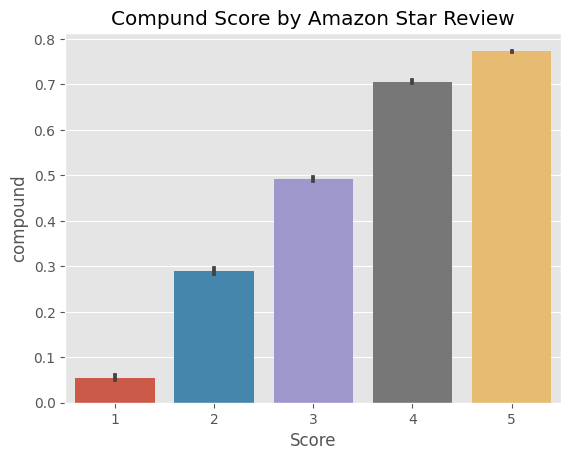

In [17]:
ax = sns.barplot(data=vader, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

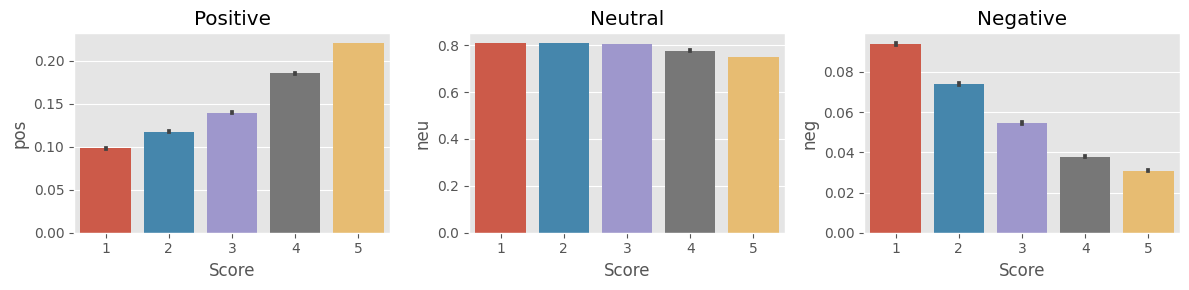

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vader, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vader, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vader, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Sentiment Analysis using Roberta

In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [20]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [22]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', truncation=True, padding=True)
    encoded_text = {k: v.to(device) for k, v in encoded_text.items()}  

    with torch.no_grad(): 
        output = model(**encoded_text)

    scores = output[0][0].detach().cpu().numpy()  
    scores = softmax(scores)

    scores_dict = {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }
    return scores_dict



In [23]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(
        example,
        return_tensors='pt',
        truncation=True,      
        max_length=512,       
        padding=True
    )
    encoded_text = {k: v.to(device) for k, v in encoded_text.items()}  

    with torch.no_grad():
        output = model(**encoded_text)

    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)

    return {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }


In [24]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']

        # VADER sentiment
        vader_result = Senti.polarity_scores(text)
        vader_result_rename = {f"vader_{k}": v for k, v in vader_result.items()}

        # RoBERTa sentiment
        roberta_result = polarity_scores_roberta(text)

        # Merge results
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both

    except RuntimeError as e:
        print(f"Broke for id {myid}: {e}")

  0%|          | 0/568454 [00:00<?, ?it/s]

In [25]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [26]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

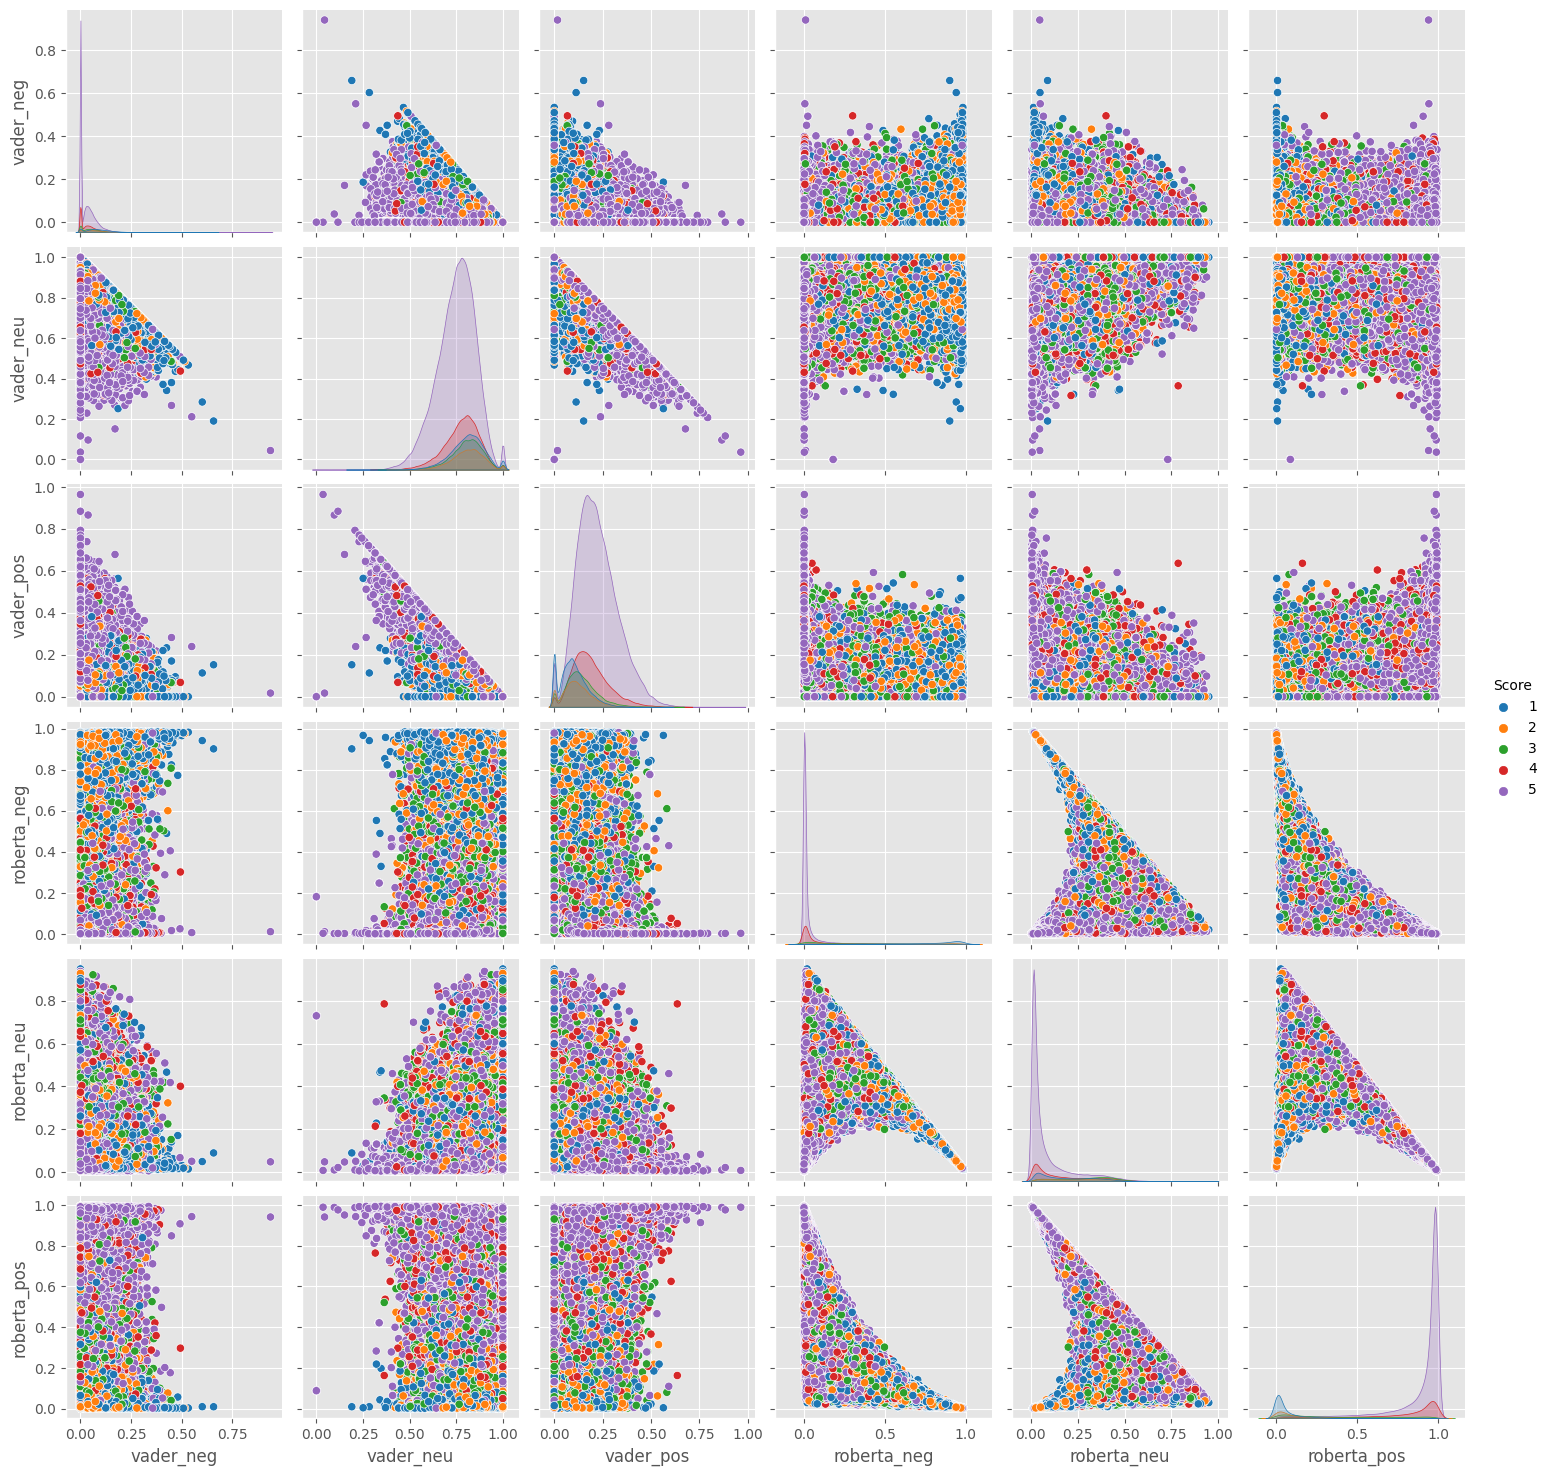

In [28]:
import numpy as np
import warnings

results_df.replace([np.inf, -np.inf], np.nan, inplace=True)

warnings.filterwarnings("ignore", category=FutureWarning)

sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [29]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"loved it! it worked better that I expected, I can't wait to order some more.  we made bath fizzies and the came out fantastic!!!"

In [30]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'Quality of product is excellent, cost is excellent and delivery is superb.  Very satisfied.'

In [33]:
# Map 'Score' to sentiment
def map_score_to_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

results_df['true_sentiment'] = results_df['Score'].apply(map_score_to_sentiment)

# Predict using VADER
def vader_sentiment(row):
    if row['vader_compound'] >= 0.05:
        return 'positive'
    elif row['vader_compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

results_df['vader_pred'] = results_df.apply(vader_sentiment, axis=1)

# Predict using RoBERTa scores
def roberta_sentiment(row):
    scores = [row['roberta_neg'], row['roberta_neu'], row['roberta_pos']]
    labels = ['negative', 'neutral', 'positive']
    return labels[np.argmax(scores)]

results_df['roberta_pred'] = results_df.apply(roberta_sentiment, axis=1)

# Accuracy
from sklearn.metrics import accuracy_score

vader_accuracy = accuracy_score(results_df['true_sentiment'], results_df['vader_pred'])
roberta_accuracy = accuracy_score(results_df['true_sentiment'], results_df['roberta_pred'])

print(f"VADER Accuracy: {vader_accuracy * 100:.2f}%")
print(f"RoBERTa Accuracy: {roberta_accuracy * 100:.2f}%")


VADER Accuracy: 79.56%
RoBERTa Accuracy: 84.52%


# Sentiment Analysis using Tranformers pipeline

In [34]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [35]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [36]:
sent_pipeline('I hate this movie')

[{'label': 'NEGATIVE', 'score': 0.9996687173843384}]